### Data extraction
Extract data from MIMIC-III

In [1]:
import pandas as pd
# Step 1

pneumonia_alive_no_disch = pd.read_csv('alive_df.csv')
pneumonia_dead_no_disch = pd.read_csv('dead_df.csv')

In [2]:
import json
# Read json
with open('word_dict.json', 'r') as fp:
    word_dict = json.load(fp)

In [3]:
from tqdm import tqdm 
import re
# import text handling tool
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

# words that do not have meaning (can be modified later)
USELESS_WORDS = ["a", "the", "he", "she", ",", ".", "?", "!", ":", ";", "+", "*", "**"\
                 "your", "you"]

# count up the frequency of every word in every disease file
stemmer = PorterStemmer()
# create set of words to ignore in text
stop_words = set(stopwords.words('english'))

for word in USELESS_WORDS:
    stop_words.add(word)

### Implementetion with python for FP_growth

### Count co-occurrences per patient

In [4]:
import os
import operator
from pathlib import Path
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import math

# ----
def fp_growth_input_per_patient_python(disease_df, word_dict, min_support):
    
    # For dataframe
    patient_cooc_dict = {}
    patient_node_dict = {}
    patient_note_cnt = {}
    
    # --------------    
    patient_id = -1
    note_cnt = 0
    patient_note_list = []
    
    # read line in from file (each line is one note)
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):
        
        # only regard certain type of notes
        patient_id_check = int(row['SUBJECT_ID_x'])
        note = re.sub(r'\[\*\*(.*?)\*\*\]|[_,\d\*:~=\.\-\+\\/]+', ' ', row['TEXT'])
        patient_word_set = set()
    
#         print(f"patient_id_check: {patient_id_check}, patient_id: {patient_id}")
        # if patient id has changed, end sequence and start new sequence
        if not patient_id == patient_id_check and not patient_id == -1:
            te = TransactionEncoder()
            te_ary = te.fit(patient_note_list).transform(patient_note_list)
            df = pd.DataFrame(te_ary, columns=te.columns_)
            df_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
            
            cooc_tmp = []
            cooc_minsup_tmp = []
            node_minsup_tmp = []
            cooc_node_idx_tmp = []
            
            for index, row in df_itemsets.iterrows():
                if len(row['itemsets']) == 1:
                    word = list(row['itemsets'])[0]
                    min_sup = row['support']

                    node_minsup_tmp.append(len(patient_note_list) * row['support'])
                    cooc_node_idx_tmp.append(word)
                    
                if len(row['itemsets']) == 2:
                    cooc_ = sorted(list(row['itemsets']))
                    cooc_tmp.append(cooc_)
                    cooc_minsup_tmp.append(len(patient_note_list) * row['support'])
            
            cooc_dict = {}

            for num, i in enumerate(cooc_tmp):
                if tuple(i) not in cooc_dict:
                    cooc_dict[tuple(i)] = cooc_minsup_tmp[num]

            # dictionary = dict(zip(keys, values))
            node_dict = {}
            for num, i in enumerate(cooc_node_idx_tmp):
                if i not in node_dict:
                    node_dict[i] = node_minsup_tmp[num]
                    
            # Update glob lists
            if patient_id not in patient_cooc_dict:
                patient_cooc_dict[patient_id] = cooc_dict
                patient_node_dict[patient_id] = node_dict
                patient_note_cnt[patient_id] = note_cnt
            else:
                print(f"patient_id: {patient_id} is already in the dictionary!")
            
            
            # Reset local lists
            patient_note_list = []
            note_cnt = 0
                    
        # update patient id
        patient_id = patient_id_check
        tokenized_note = word_tokenize(note)
        note_cnt += 1

        # loop through each word in note to count word belonging to each disease
        for word in tokenized_note:
            stemmed_word = stemmer.stem(word.lower())       
            if stemmed_word in word_dict:
                    patient_word_set.add(stemmed_word)

        templst = []
        for word in patient_word_set:
            templst.append(word)

        if templst:
            patient_note_list.append(templst)
    
    # Last patient info
    te = TransactionEncoder()
    te_ary = te.fit(patient_note_list).transform(patient_note_list)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    df_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
            
    cooc_tmp = []
    cooc_minsup_tmp = []
    #-----
    node_minsup_tmp = []
    cooc_node_idx_tmp = []
            
    for index, row in df_itemsets.iterrows():
        if len(row['itemsets']) == 1:
            word = list(row['itemsets'])[0]
            node_minsup_tmp.append(len(patient_note_list) * row['support'])
            cooc_node_idx_tmp.append(word)

        if len(row['itemsets']) == 2:
            cooc_ = sorted(list(row['itemsets']))
            cooc_tmp.append(cooc_)
            cooc_minsup_tmp.append(len(patient_note_list) * row['support'])
    
                    
    cooc_dict = {}

    for num, i in enumerate(cooc_tmp):
        if tuple(i) not in cooc_dict:
            cooc_dict[tuple(i)] = cooc_minsup_tmp[num]

    # dictionary = dict(zip(keys, values))
    node_dict = {}
    for num, i in enumerate(cooc_node_idx_tmp):
        if i not in node_dict:
            node_dict[i] = node_minsup_tmp[num]

    # Update glob lists
    if patient_id not in patient_cooc_dict:
        patient_cooc_dict[patient_id] = cooc_dict
        patient_node_dict[patient_id] = node_dict
        patient_note_cnt[patient_id] = note_cnt
    else:
        print(f"patient_id: {patient_id} is already in the dictionary!")

    return patient_node_dict, patient_cooc_dict, patient_note_cnt

patient_node_0, patient_cooc_0, patient_note_num_0 = fp_growth_input_per_patient_python(pneumonia_dead_no_disch, word_dict, 0.15)
patient_node_1, patient_cooc_1, patient_note_num_1 = fp_growth_input_per_patient_python(pneumonia_alive_no_disch, word_dict, 0.15)

100%|██████████| 46134/46134 [05:30<00:00, 139.74it/s] 


In [5]:
print(patient_node_1)

{68: {'commod': 4.0, 'ambul': 4.0, 'gait': 2.0, 'chair': 2.0, 'oob': 2.0}, 85: {'lat': 1.0}, 94: {'lift': 11.0, 'dopamin': 11.0}, 165: {'habitu': 1.0}, 211: {'dopamin': 3.0, 'aox': 3.0, 'levoph': 3.0}, 224: {'lat': 1.0, 'rigor': 1.0, 'platelet': 1.0, 'commod': 1.0, 'awhil': 1.0, 'fax': 1.0, 'bank': 1.0, 'pleasant': 1.0, 'chair': 1.0}, 231: {}, 283: {'recruit': 10.0, 'criticar': 10.0}, 357: {'unasyn': 4.0, 'intent': 2.0, 'dz': 2.0, 'ctx': 2.0, 'moan': 4.0, 'distort': 2.0}, 368: {'pleasant': 3.0, 'dnr': 3.0, 'hhn': 3.0, 'oob': 6.0, 'ambul': 4.0}, 370: {'dnr': 2.0}, 384: {'bipolar': 9.0, 'wish': 4.0, 'dnr': 3.0, 'schizophrenia': 4.0}, 426: {'align': 1.0, 'mottl': 1.0, 'lat': 1.0, 'unenhanc': 1.0, 'mail': 1.0, 'bronchovascular': 1.0, 'pleasant': 1.0, 'arthrit': 1.0}, 509: {'oob': 3.0}, 514: {'lat': 1.0, 'schizophrenia': 1.0, 'nicotin': 1.0, 'lighthead': 1.0, 'burn': 1.0, 'pleasant': 2.0, 'commod': 2.0, 'ambul': 1.0, 'oob': 1.0}, 596: {'dnr': 4.0, 'dopamin': 3.0, 'dni': 4.0, 'chair': 2.0}, 

In [6]:
print(patient_cooc_1)

{68: {('ambul', 'commod'): 3.0, ('ambul', 'oob'): 2.0, ('commod', 'oob'): 2.0}, 85: {}, 94: {}, 165: {}, 211: {}, 224: {('platelet', 'rigor'): 1.0, ('commod', 'platelet'): 1.0, ('commod', 'rigor'): 1.0, ('bank', 'fax'): 1.0, ('chair', 'pleasant'): 1.0}, 231: {}, 283: {}, 357: {('intent', 'unasyn'): 2.0, ('dz', 'intent'): 2.0, ('dz', 'unasyn'): 2.0, ('ctx', 'unasyn'): 2.0}, 368: {}, 370: {}, 384: {('bipolar', 'wish'): 4.0}, 426: {('lat', 'mottl'): 1.0, ('mail', 'unenhanc'): 1.0, ('bronchovascular', 'mail'): 1.0, ('bronchovascular', 'unenhanc'): 1.0, ('arthrit', 'pleasant'): 1.0}, 509: {}, 514: {('nicotin', 'schizophrenia'): 1.0, ('lighthead', 'nicotin'): 1.0, ('lighthead', 'schizophrenia'): 1.0, ('burn', 'lighthead'): 1.0, ('burn', 'nicotin'): 1.0, ('burn', 'schizophrenia'): 1.0, ('commod', 'pleasant'): 2.0, ('ambul', 'commod'): 1.0, ('ambul', 'pleasant'): 1.0, ('commod', 'oob'): 1.0, ('oob', 'pleasant'): 1.0}, 596: {('dni', 'dnr'): 2.0}, 674: {('nimv', 'profound'): 1.0, ('rememb', 'xl'

In [7]:
patient_note_num_0

{111: 12,
 346: 25,
 404: 3,
 546: 6,
 618: 16,
 705: 15,
 726: 48,
 1039: 55,
 1556: 37,
 1872: 3,
 1944: 56,
 2286: 69,
 2990: 166,
 3055: 29,
 3099: 13,
 3201: 8,
 3526: 7,
 3773: 6,
 3881: 20,
 4122: 51,
 4754: 101,
 4811: 21,
 5476: 1,
 5494: 22,
 5774: 104,
 5786: 152,
 5913: 1,
 6133: 68,
 6735: 13,
 6745: 13,
 6973: 36,
 6981: 8,
 7277: 66,
 7310: 8,
 7924: 9,
 7977: 9,
 9908: 11,
 9984: 15,
 10302: 100,
 10510: 86,
 10545: 10,
 10642: 10,
 11049: 14,
 11209: 9,
 11395: 41,
 12530: 24,
 12849: 50,
 13098: 46,
 13566: 23,
 14125: 9,
 14514: 96,
 14965: 25,
 15159: 15,
 15251: 11,
 15396: 17,
 15566: 37,
 15853: 45,
 16275: 17,
 16344: 27,
 16622: 51,
 16684: 29,
 17122: 16,
 17354: 5,
 17802: 64,
 17983: 65,
 18094: 23,
 18736: 35,
 18768: 46,
 18848: 205,
 18971: 26,
 19243: 25,
 19323: 6,
 19390: 21,
 19463: 20,
 19535: 59,
 19754: 13,
 19827: 22,
 19833: 58,
 19872: 10,
 20006: 8,
 20023: 9,
 20190: 6,
 21046: 101,
 21094: 36,
 21427: 10,
 21502: 102,
 21580: 52,
 21676: 12,


#### Create set of patient co-occurrences from two groups

In [8]:
# Create a set of all unique co-occurrences from both group
patient_cooc_set = set()
patient_cooc_0_dict = {}
patient_cooc_1_dict = {}

for k, v in patient_cooc_0.items():
    for item in v:
        patient_cooc_set.add(item)
        if item not in patient_cooc_0_dict:
            patient_cooc_0_dict[item] = v[item]
        else:
            patient_cooc_0_dict[item] = patient_cooc_0_dict[item] + v[item]
            
    
for k, v in patient_cooc_1.items():
    for item in v:
        patient_cooc_set.add(item)
        if item not in patient_cooc_1_dict:
            patient_cooc_1_dict[item] = v[item]
        else:
            patient_cooc_1_dict[item] = patient_cooc_1_dict[item] + v[item]

In [9]:
print(len(patient_cooc_set))
print(len(patient_cooc_0_dict))
print(len(patient_cooc_1_dict))

6776
1989
5152


In [10]:
# count log-odds score

# reverse
# --------------- co-occurrences --------------->

        
# Get the set of coocurrencies from two groups
# Count log_odd_score

patient_cooc_odd_scores = {}
for set_item in patient_cooc_set:
    if set_item in patient_cooc_0_dict and set_item in patient_cooc_1_dict: 
        d_prob = patient_cooc_0_dict[set_item]/(patient_cooc_0_dict[set_item] + patient_cooc_1_dict[set_item])
        a_prob = patient_cooc_1_dict[set_item]/(patient_cooc_0_dict[set_item] + patient_cooc_1_dict[set_item])
        log_odd_score = math.log((a_prob + 0.001)/(d_prob+0.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
    elif set_item in patient_cooc_0_dict:
        log_odd_score = math.log((0.001)/(1.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
    elif set_item in patient_cooc_1_dict:
        log_odd_score = math.log((1.001)/(0.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
# --------------- co-occurrences ---------------<

In [11]:
patient_cooc_odd_scores

{('ultrafiltr', 'xl'): 6.90875477931522,
 ('rhinorrhea', 'xii'): -6.90875477931522,
 ('death', 'moan'): -6.90875477931522,
 ('hepatobiliari', 'levoph'): -6.90875477931522,
 ('arrest', 'impli'): 6.90875477931522,
 ('chb', 'dic'): -0.0391424082847512,
 ('klonopin', 'mycolyt'): 6.90875477931522,
 ('deterior', 'opiat'): 6.90875477931522,
 ('fdp', 'petechia'): -6.90875477931522,
 ('gabapentin', 'tremul'): 6.90875477931522,
 ('ciwa', 'pneumococc'): 6.90875477931522,
 ('anaphylaxi', 'opiat'): 6.90875477931522,
 ('ciwa', 'cocain'): 6.90875477931522,
 ('scar', 'xopenex'): -6.90875477931522,
 ('cooki', 'silent'): 6.90875477931522,
 ('amb', 'chair'): 6.90875477931522,
 ('schizophrenia', 'soln'): 6.90875477931522,
 ('chair', 'ppn'): 6.90875477931522,
 ('cocain', 'dizzi'): 6.90875477931522,
 ('aox', 'ctx'): 6.90875477931522,
 ('ctx', 'diflucan'): 6.90875477931522,
 ('nifedipin', 'zero'): 6.90875477931522,
 ('epidur', 'norepinephrin'): 6.90875477931522,
 ('life', 'religi'): -6.90875477931522,
 ('ali

### Train mode

#### Method 2. Each patient graph => [model training]

In [12]:
# Dictionaries to use
 # struct: {word: word2vec[128, numpy.array]}
patient_cooc_odd_scores # struct: {cooc_tuple: log_odds_score}
print()

In [13]:
patient_cooc_odd_scores 

{('ultrafiltr', 'xl'): 6.90875477931522,
 ('rhinorrhea', 'xii'): -6.90875477931522,
 ('death', 'moan'): -6.90875477931522,
 ('hepatobiliari', 'levoph'): -6.90875477931522,
 ('arrest', 'impli'): 6.90875477931522,
 ('chb', 'dic'): -0.0391424082847512,
 ('klonopin', 'mycolyt'): 6.90875477931522,
 ('deterior', 'opiat'): 6.90875477931522,
 ('fdp', 'petechia'): -6.90875477931522,
 ('gabapentin', 'tremul'): 6.90875477931522,
 ('ciwa', 'pneumococc'): 6.90875477931522,
 ('anaphylaxi', 'opiat'): 6.90875477931522,
 ('ciwa', 'cocain'): 6.90875477931522,
 ('scar', 'xopenex'): -6.90875477931522,
 ('cooki', 'silent'): 6.90875477931522,
 ('amb', 'chair'): 6.90875477931522,
 ('schizophrenia', 'soln'): 6.90875477931522,
 ('chair', 'ppn'): 6.90875477931522,
 ('cocain', 'dizzi'): 6.90875477931522,
 ('aox', 'ctx'): 6.90875477931522,
 ('ctx', 'diflucan'): 6.90875477931522,
 ('nifedipin', 'zero'): 6.90875477931522,
 ('epidur', 'norepinephrin'): 6.90875477931522,
 ('life', 'religi'): -6.90875477931522,
 ('ali

In [14]:
# Data normalization
import numpy
def data_norm(cooc_odd_scores):

    def norm_arr(array):
        arr = numpy.array(list(array))
        start = 0
        end = 1
        width = end - start
        res = (arr - arr.min())/(arr.max() - arr.min()) * width + start
        return res.tolist()

    cooc_keys, cooc_values = zip(*cooc_odd_scores.items())
    new_cooc_odd_scores = dict(zip(cooc_keys, norm_arr(cooc_values)))

    return new_cooc_odd_scores

new_patient_cooc_odd_scores = data_norm(patient_cooc_odd_scores)

In [15]:
new_patient_cooc_odd_scores

{('ultrafiltr', 'xl'): 1.0,
 ('rhinorrhea', 'xii'): 0.0,
 ('death', 'moan'): 0.0,
 ('hepatobiliari', 'levoph'): 0.0,
 ('arrest', 'impli'): 1.0,
 ('chb', 'dic'): 0.4971671878989002,
 ('klonopin', 'mycolyt'): 1.0,
 ('deterior', 'opiat'): 1.0,
 ('fdp', 'petechia'): 0.0,
 ('gabapentin', 'tremul'): 1.0,
 ('ciwa', 'pneumococc'): 1.0,
 ('anaphylaxi', 'opiat'): 1.0,
 ('ciwa', 'cocain'): 1.0,
 ('scar', 'xopenex'): 0.0,
 ('cooki', 'silent'): 1.0,
 ('amb', 'chair'): 1.0,
 ('schizophrenia', 'soln'): 1.0,
 ('chair', 'ppn'): 1.0,
 ('cocain', 'dizzi'): 1.0,
 ('aox', 'ctx'): 1.0,
 ('ctx', 'diflucan'): 1.0,
 ('nifedipin', 'zero'): 1.0,
 ('epidur', 'norepinephrin'): 1.0,
 ('life', 'religi'): 0.0,
 ('aliv', 'jewelri'): 1.0,
 ('cocain', 'phlegm'): 1.0,
 ('cagluc', 'vasopressin'): 0.0,
 ('dead', 'phenylephrin'): 0.0,
 ('clonazepam', 'nocturn'): 1.0,
 ('bair', 'vasopressor'): 0.0,
 ('bottl', 'opiat'): 1.0,
 ('cash', 'oob'): 1.0,
 ('sensat', 'suprapub'): 1.0,
 ('led', 'leukocyt'): 0.0,
 ('dni', 'morgu'): 0.0

In [16]:
# patient_dead_cooc_df
print(patient_cooc_0)

{111: {('arrest', 'pea'): 5.0, ('cpr', 'pea'): 4.0, ('arrest', 'cpr'): 4.0, ('cpr', 'vasopressin'): 4.0, ('pea', 'vasopressin'): 4.0, ('arrest', 'vasopressin'): 4.0, ('pcv', 'vasopressin'): 2.0, ('cpr', 'pcv'): 2.0, ('pcv', 'pea'): 2.0, ('arrest', 'pcv'): 2.0, ('paralyt', 'pcv'): 2.0, ('paralyt', 'vasopressin'): 2.0, ('cpr', 'paralyt'): 2.0, ('paralyt', 'pea'): 2.0, ('arrest', 'paralyt'): 2.0, ('norepinephrin', 'paralyt'): 2.0, ('norepinephrin', 'pcv'): 2.0, ('norepinephrin', 'vasopressin'): 2.0, ('cpr', 'norepinephrin'): 2.0, ('norepinephrin', 'pea'): 2.0, ('arrest', 'norepinephrin'): 2.0, ('hypothermia', 'norepinephrin'): 2.0, ('hypothermia', 'paralyt'): 2.0, ('hypothermia', 'pcv'): 2.0, ('hypothermia', 'vasopressin'): 2.0, ('cpr', 'hypothermia'): 2.0, ('hypothermia', 'pea'): 2.0, ('arrest', 'hypothermia'): 2.0, ('hypercapnia', 'hypothermia'): 2.0, ('hypercapnia', 'norepinephrin'): 2.0, ('hypercapnia', 'paralyt'): 2.0, ('hypercapnia', 'pcv'): 2.0, ('hypercapnia', 'vasopressin'): 2.0,

In [17]:
print(patient_node_0)

{111: {'arrest': 6.0, 'pea': 5.0, 'cpr': 4.0, 'vasopressin': 4.0, 'pcv': 2.0, 'paralyt': 2.0, 'norepinephrin': 2.0, 'hypothermia': 2.0, 'hypercapnia': 2.0, 'dic': 2.0, 'phenylephrin': 2.0, 'bicarbon': 2.0, 'azotemia': 2.0, 'autopeep': 2.0, 'death': 3.0, 'clinician': 2.0, 'profound': 2.0, 'expir': 2.0}, 346: {'arrest': 4.0, 'sluggish': 6.0}, 404: {'paco': 1.0, 'death': 1.0}, 546: {'oder': 1.0, 'hurt': 1.0, 'historian': 1.0}, 618: {'video': 2.0}, 705: {'dnr': 5.0, 'dni': 2.0, 'cmo': 5.0, 'mso': 2.0}, 726: {'mso': 3.0, 'dnr': 3.0}, 1039: {'wish': 4.0}, 1556: {'mso': 13.0, 'dnr': 8.0, 'dni': 8.0}, 1872: {'pronounc': 1.0}, 1944: {'arrest': 4.0, 'cvvhd': 5.0}, 2286: {'cyanot': 17.0, 'vasopressin': 14.0, 'levoph': 8.0, 'dnr': 7.0, 'prognosi': 7.0, 'purpl': 10.0, 'mottl': 7.0, 'pitressin': 15.0, 'incis': 10.0, 'anur': 9.0, 'cvvh': 9.0, 'hugger': 7.0, 'bair': 7.0}, 2990: {'chair': 17.0, 'oob': 17.0, 'levoph': 31.0, 'anur': 24.0}, 3055: {'gc': 3.0, 'wish': 3.0, 'cmo': 4.0}, 3099: {'neo': 2.0, 'n

In [18]:
# Count support of each node
patient_node_set = set()
patient_node_0_dict = {}
patient_node_1_dict = {}
    
for k, v in patient_node_0.items():
    for item in v:
        patient_node_set.add(item)
        
        if item not in patient_node_0_dict:
            patient_node_0_dict[item] = v[item]
        else:
            patient_node_0_dict[item] = patient_node_0_dict[item] + v[item]
        
    
for k, v in patient_node_1.items():
    for item in v:
        patient_node_set.add(item)
        
        if item not in patient_node_1_dict:
            patient_node_1_dict[item] = v[item]
        else:
            patient_node_1_dict[item] = patient_node_1_dict[item] + v[item]
        


In [19]:
print(len(patient_node_set))
print(len(patient_node_0_dict))
print(len(patient_node_1_dict))

633
379
571


In [20]:
patient_node_odd_scores = {}

for set_item in patient_node_set:
    if set_item in patient_node_0_dict and set_item in patient_node_1_dict:
        d_prob = patient_node_0_dict[set_item]/(patient_node_0_dict[set_item] + patient_node_1_dict[set_item])
        a_prob = patient_node_1_dict[set_item]/(patient_node_0_dict[set_item] + patient_node_1_dict[set_item])
        log_odd_score = math.log((a_prob + 0.001)/(d_prob+0.001))
        patient_node_odd_scores[set_item] = log_odd_score
    elif set_item in patient_node_0_dict:
        log_odd_score = math.log((0.001)/(1.001))
        patient_node_odd_scores[set_item] = log_odd_score
    elif set_item in patient_node_1_dict:
        log_odd_score = math.log((1.001)/(0.001))
        patient_node_odd_scores[set_item] = log_odd_score

In [21]:
print(patient_node_odd_scores)

{'book': 6.90875477931522, 'imbal': 6.90875477931522, 'modifi': 6.90875477931522, 'pneumonectomi': 1.782563518479713, 'shorter': 0.8734901684270467, 'amb': 6.90875477931522, 'chb': 0.6077720443224599, 'cg': -6.90875477931522, 'signatur': 2.601472222000523, 'aox': 2.6932429501279174, 'svn': 6.90875477931522, 'rabbi': -6.90875477931522, 'wallet': 2.2927445483990123, 'vigil': 6.90875477931522, 'seat': 1.4311353280322385, 'fu': 2.8726050025040895, 'chol': -6.90875477931522, 'virtual': 0.0, 'money': 2.5001408943598484, 'acv': 6.90875477931522, 'mail': 6.90875477931522, 'aglc': 6.90875477931522, 'unsteadi': 6.90875477931522, 'dorsal': 0.6916505477038827, 'vp': 6.90875477931522, 'td': 6.90875477931522, 'gasp': -6.90875477931522, 'caspofungin': 0.606820385290549, 'hygein': 6.90875477931522, 'stitch': 6.90875477931522, 'anur': 1.192708417873802, 'rehabilit': 6.90875477931522, 'abnl': 6.90875477931522, 'wether': 6.90875477931522, 'leukocyt': 0.6916505477038827, 'ud': 6.90875477931522, 'slice': 2

In [22]:
patient_square_node_data = pd.DataFrame({'node':list(patient_node_odd_scores.keys()), 'feature':list(patient_node_odd_scores.values())})
patient_square_node_data

,node,feature
0,book,6.908755
1,imbal,6.908755
2,modifi,6.908755
3,pneumonectomi,1.782564
4,shorter,0.873490
...,...,...
628,mellitu,3.633556
629,hunger,-1.865483
630,postop,2.659836
631,cramp,6.908755


In [23]:
patient_square_node_id_data = patient_square_node_data.set_index("node")
patient_square_node_id_data['subject'] = ["positive" if r['feature'] > 0 else "negative" for i, r in patient_square_node_id_data.iterrows()]
patient_square_node_id_data

,feature,subject
node,,
book,6.908755,positive
imbal,6.908755,positive
modifi,6.908755,positive
pneumonectomi,1.782564,positive
shorter,0.873490,positive
...,...,...
mellitu,3.633556,positive
hunger,-1.865483,negative
postop,2.659836,positive


In [24]:
patient_subjects = patient_square_node_id_data["subject"]
patient_subjects

node
book             positive
imbal            positive
modifi           positive
pneumonectomi    positive
shorter          positive
                   ...   
mellitu          positive
hunger           negative
postop           positive
cramp            positive
agreement        negative
Name: subject, Length: 633, dtype: object

In [25]:
patient_square_node_data_no_feature = patient_square_node_id_data.drop(columns=["feature","subject"])
patient_square_node_data_no_feature

""
node
book
imbal
modifi
pneumonectomi
shorter
...
mellitu
hunger
postop


In [26]:
from sklearn.manifold import TSNE
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec

### Create a bi-directional df

In [27]:
# with edge weight
bidirect_source = []
bidirect_target = []
edge_weight = []

for item, val in new_patient_cooc_odd_scores.items():
    bidirect_source.extend([item[0], item[1]])
    bidirect_target.extend([item[1], item[0]])
    edge_weight.extend([val, val])
    
print(f"source: {len(bidirect_source)}, target: {len(bidirect_target)}")

weighted_patient_bidirect_square_edge_data = pd.DataFrame(
    {
        "source": bidirect_source,
        "target": bidirect_target,
        "weight": edge_weight,
    })
weighted_patient_bidirect_square_edge_data

source: 13552, target: 13552


,source,target,weight
0,ultrafiltr,xl,1.000000
1,xl,ultrafiltr,1.000000
2,rhinorrhea,xii,0.000000
3,xii,rhinorrhea,0.000000
4,death,moan,0.000000
...,...,...,...
13547,wallet,dni,0.470716
13548,acc,hsq,1.000000
13549,hsq,acc,1.000000
13550,romi,scar,1.000000


In [28]:
# Weighted
G_weighted_patient_bidirect = StellarGraph(
    {"corner": patient_square_node_data_no_feature}, {"line": weighted_patient_bidirect_square_edge_data}
)
print(G_weighted_patient_bidirect.info())

StellarGraph: Undirected multigraph
 Nodes: 633, Edges: 13552

 Node types:
  corner: [633]
    Features: none
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [13552]
        Weights: range=[0, 1], mean=0.734681, std=0.426758
        Features: none


In [29]:
rw_weighted_patient_bidirect = BiasedRandomWalk(G_weighted_patient_bidirect)

In [30]:
# Weighted
weighted_walks_patient_bidirect = rw_weighted_patient_bidirect.run(
    nodes=G_weighted_patient_bidirect.nodes(),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
#     weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks_patient_bidirect)))

Number of random walks: 6330


In [31]:
print(weighted_walks_patient_bidirect[0])

['book', 'ambul', 'chair', 'incent', 'silent', 'ctx', 'romi', 'dermat', 'sarna', 'refractori', 'sarna', 'metoclopramid', 'young', 'ppd', 'gabapentin', 'asthma', 'xl', 'norepinephrin', 'neo', 'asthma', 'eg', 'anaphylaxi', 'thrive', 'anaphylaxi', 'levoph', 'dni', 'broader', 'dnr', 'readdress', 'hive', 'anaphylaxi', 'romi', 'motor', 'oncologist', 'massag', 'phenylephrin', 'arrest', 'gum', 'bottl', 'incis', 'bottl', 'syncop', 'colonoscopi', 'ppd', 'dnr', 'arthrit', 'dnr', 'readdress', 'norepinephrin', 'metoclopramid', 'gabapentin', 'colonoscopi', 'ppd', 'cash', 'asthma', 'ctx', 'levoph', 'dex', 'nonrebreath', 'incent', 'ctx', 'readdress', 'neo', 'asthma', 'ambul', 'opiat', 'anaphylaxi', 'ambul', 'gabapentin', 'aricept', 'epidur', 'levoph', 'bicarbon', 'sluggishli', 'cvvh', 'esld', 'venti', 'cracker', 'nonlabor', 'subq', 'motor', 'pneumococc', 'ciwa', 'crack', 'azotemia', 'petechia', 'rhinorrhea', 'myeloma', 'anur', 'judgement', 'dnr', 'mortem', 'sluggish', 'vasopressor', 'moan', 'dni', 'me

In [32]:
# Weighted
weighted_model_patient = Word2Vec(
    weighted_walks_patient_bidirect, size=128, window=5, min_count=0, sg=1, workers=4, iter=1
)

In [33]:
# Weighted
emb = weighted_model_patient.wv["cmo"]
emb

array([ 0.07991296, -0.12830059, -0.56315166,  0.1594525 ,  0.01822246,
       -0.16933894,  0.32672974,  0.2572589 , -0.05548313, -0.14837414,
        0.14106655,  0.08687793,  0.04315631,  0.03837093,  0.10449327,
        0.2906883 , -0.0699701 ,  0.2024141 , -0.06369358,  0.51435006,
        0.11183619,  0.0314883 , -0.41315925,  0.06952988,  0.20808859,
        0.17971696, -0.2175687 , -0.1283321 ,  0.3204166 ,  0.04256547,
        0.03048401, -0.16892013,  0.09234884, -0.15462057,  0.13362312,
        0.05674893,  0.21870747, -0.04840972,  0.01228869, -0.25879726,
        0.28186586, -0.07207984, -0.22438593, -0.20731191, -0.08033711,
       -0.29729733,  0.0033833 , -0.02531351, -0.03580109, -0.29459184,
       -0.01467347,  0.26355392,  0.05243672,  0.28022587,  0.2578414 ,
        0.35896325, -0.17100753, -0.04565158, -0.06037717, -0.10495133,
       -0.24303287,  0.3353422 , -0.21277018,  0.12486095,  0.02637048,
        0.1415815 , -0.12308713, -0.04648803,  0.30560163, -0.08

In [34]:
weighted_model_patient.wv["sxn'ing"]

array([ 0.11137933, -0.2148601 , -0.08655566, -0.11608012, -0.09682464,
       -0.1042059 , -0.07177353,  0.25757438, -0.02502798, -0.01627925,
        0.10292049,  0.27887368, -0.12510166, -0.02448946,  0.0207245 ,
        0.06011655, -0.12468455,  0.05038656, -0.02279986,  0.32286918,
        0.01346958,  0.23404287, -0.05055163,  0.06421037,  0.16125461,
        0.07362398, -0.15778638,  0.08555217,  0.16023654,  0.26561818,
        0.02683025, -0.01204978, -0.1332451 ,  0.01360178,  0.08257122,
        0.00513953,  0.17855254, -0.07815534, -0.07734266, -0.06160967,
        0.04949275,  0.09505962, -0.11026219, -0.16997017,  0.0985916 ,
       -0.09671221, -0.2296711 ,  0.00552446, -0.28881758, -0.18149942,
       -0.22389174,  0.12178059, -0.06463683,  0.08298397, -0.12602551,
        0.18625702, -0.02749203,  0.02316557,  0.10401135,  0.05860463,
       -0.0520493 ,  0.05288179, -0.27411273,  0.20153736, -0.07654388,
        0.01289599,  0.04497198,  0.08936287,  0.15534152,  0.06

### Visualise Node Embeddings generated by weighted random walks

### Weighted edges

In [35]:
# Retrieve node embeddings and corresponding subjects
patient_weighted_node_ids = weighted_model_patient.wv.index2word  # list of node IDs
patient_weighted_node_embeddings = (
    weighted_model_patient.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# the gensim ordering may not match the StellarGraph one, so rearrange
patient_node_targets = patient_subjects.loc[patient_weighted_node_ids].astype("category")

In [36]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
patient_weighted_node_embeddings_2d = tsne.fit_transform(patient_weighted_node_embeddings)

### Not weighted random walk

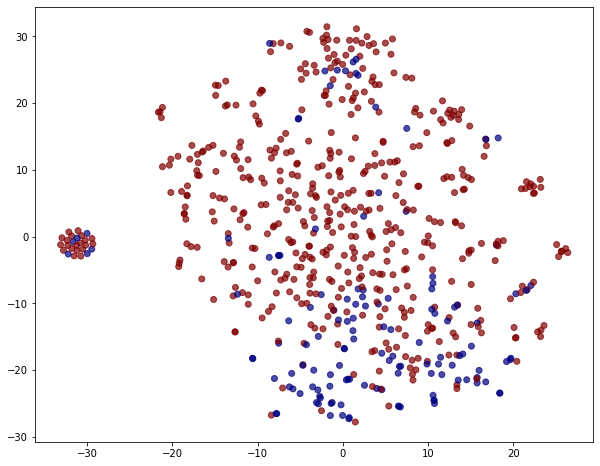

In [37]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    patient_weighted_node_embeddings_2d[:, 0],
    patient_weighted_node_embeddings_2d[:, 1],
    c=patient_node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

### Weighted random walk

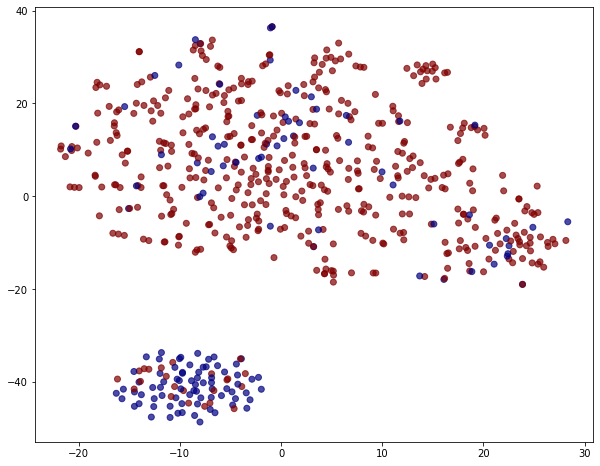

In [36]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    patient_weighted_node_embeddings_2d[:, 0],
    patient_weighted_node_embeddings_2d[:, 1],
    c=patient_node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

In [37]:
patient_weighted_node_emb_dict = {}
for index, row in patient_square_node_data_no_feature.iterrows():
    if index not in patient_weighted_node_emb_dict:
        patient_weighted_node_emb_dict[index] = weighted_model_patient.wv[index]
    else:
        print(f"index: {index} is already in a dictionary!")

In [38]:
# print(type(patient_weighted_node_emb_dict['aprv']))